# **`Movies Recommendation Engine`**


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset**



In [ ]:
movies_df = pd.read_csv('/content/drive/MyDrive/recommendations/movies.csv')
ratings_df = pd.read_csv('/content/drive/MyDrive/recommendations/ratings.csv')

**Movies.csv**

***movieId*** – once the recommendation is done, we get a list of all similar movieId and get the title for each movie from this dataset.

***genres*** – The type of movie.

In [ ]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies_df.shape

(10329, 3)

**Ratings.csv**

***userId*** – unique for each user.

***movieId*** – uniques movie ID to fetch the title.

***rating*** – Ratings given by each user to all the movies using this we are going to predict the top similar movies user can watch.

***Timestamp*** – timestamp of rating.

In [ ]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


# Data Processing

**Timestamp to date time conversion**

In [ ]:
ratings_df["timestamp"]= pd.to_datetime(ratings_df.timestamp)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1970-01-01 00:00:01.217897793
1,1,24,1.5,1970-01-01 00:00:01.217895807
2,1,32,4.0,1970-01-01 00:00:01.217896246
3,1,47,4.0,1970-01-01 00:00:01.217896556
4,1,50,4.0,1970-01-01 00:00:01.217896523


**Number of Unique Users and Movies in dataset**

In [ ]:
print(f"Number of Unique Users: {ratings_df['userId'].nunique()}")
print(f"Number of Movies: {ratings_df['movieId'].nunique()}")


Number of Unique Users: 668
Number of Movies: 10325


**Merge Movies and Ratings Dataset**

In [ ]:
all_movies  = pd.merge(left=movies_df, right=ratings_df, how='left', on = 'movieId')
print('Total dataset: {}'.format(all_movies.shape[0]))
all_movies

Total dataset: 105343


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1970-01-01 00:00:01.303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,5.0,1970-01-01 00:00:00.858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.0,1970-01-01 00:00:00.850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.0,1970-01-01 00:00:00.851766286
...,...,...,...,...,...,...
105338,148238,A Very Murray Christmas (2015),Comedy,475.0,3.0,1970-01-01 00:00:01.451213043
105339,148626,The Big Short (2015),Drama,458.0,4.0,1970-01-01 00:00:01.452014749
105340,148626,The Big Short (2015),Drama,576.0,4.5,1970-01-01 00:00:01.451687664
105341,148626,The Big Short (2015),Drama,668.0,4.5,1970-01-01 00:00:01.451148148


**Box Plot**

As, we can see there are not enough outliers in user rating's , we don't need to remove the outlier's here 

(105343, 6)

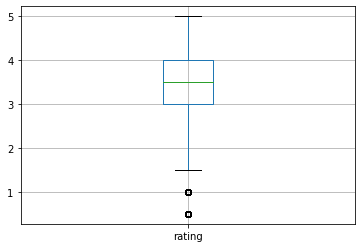

In [ ]:
all_movies.boxplot(column=['rating'])
all_movies.shape



**dataset information**

In [ ]:
print(all_movies.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105343 entries, 0 to 105342
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   movieId    105343 non-null  int64         
 1   title      105343 non-null  object        
 2   genres     105343 non-null  object        
 3   userId     105339 non-null  float64       
 4   rating     105339 non-null  float64       
 5   timestamp  105339 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 5.6+ MB
None


**dataset description**

In [ ]:
print(all_movies.describe())

             movieId         userId         rating
count  105343.000000  105339.000000  105339.000000
mean    13382.696373     364.924539       3.516850
std     26172.698128     197.486905       1.044872
min         1.000000       1.000000       0.500000
25%      1073.000000     192.000000       3.000000
50%      2497.000000     383.000000       3.500000
75%      5991.000000     557.000000       4.000000
max    149532.000000     668.000000       5.000000


**Create Matrices for Users and Movies Ratings**

In [ ]:
user_item_matrix = ratings_df.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
print("User Item Matrix Shape: ", user_item_matrix.shape)

user_item_matrix.head()

User Item Matrix Shape:  (10325, 668)


userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668
0,NaN,5.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,4.5,4.0,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,4.0,NaN,4.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,3.0,NaN,NaN,NaN,NaN,3.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.5,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,3.0
2,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,3.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,2.5


**Replace Missing Values in user_item_matrix**

In [ ]:
user_item_matrix.fillna(0,inplace=True)
user_item_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668
0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.5,4.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,3.0,0.0,0.0,5.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.5,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
2,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


**Geners**

replace empity geners with string "no genres listed" and split "|" into list seprated by comma.

In [ ]:
movies_df['genres'] = movies_df['genres'].replace(to_replace="(no genres listed)", value="") 
generlist = movies_df['genres'].apply(lambda allgeners : str(allgeners).split("|"))
generlist

0        [Adventure, Animation, Children, Comedy, Fantasy]
1                           [Adventure, Children, Fantasy]
2                                        [Comedy, Romance]
3                                 [Comedy, Drama, Romance]
4                                                 [Comedy]
                               ...                        
10324                        [Animation, Children, Comedy]
10325                                             [Comedy]
10326                                             [Comedy]
10327                                              [Drama]
10328                                                   []
Name: genres, Length: 10329, dtype: object

In [ ]:

geners_count = {}
for generlist_movie in generlist:
    for gener in generlist_movie:
        if(geners_count.get(gener,False)):
            geners_count[gener]=geners_count[gener]+1
        else:
            geners_count[gener] = 1       
geners_count.keys()

dict_keys(['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir', ''])

In [ ]:
from scipy.stats import itemfreq
print(itemfreq(generlist))

[[list(['']) 7]
 [list(['Action']) 48]
 [list(['Action', 'Adventure']) 32]
 ...
 [list(['Thriller', 'War']) 7]
 [list(['War']) 10]
 [list(['Western']) 66]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:     `itemfreq` is deprecated!
    `itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


# Exploratory Data Analysis

**Top 10 most rated movies**

Top movie is Pulp Fiction(1994), which has more then 300 ratings.

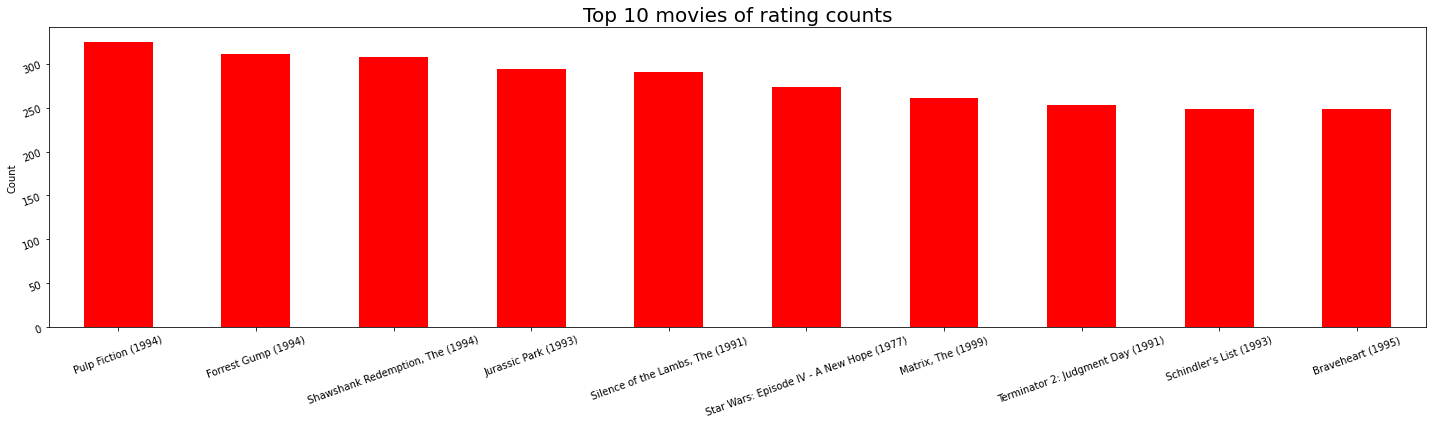

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,6))
all_movies['title'].value_counts()[:10].plot(kind = 'bar', ax = ax, color="red")
ax.set_title('Top 10 movies of rating counts', fontsize = 20)
ax.tick_params(labelrotation = 20)
ax.set_ylabel('Movies Title')
ax.set_ylabel('Count')
plt.tight_layout()

**Top 10 Users in the dataset based on ratings count**

Top user with UserId is 668 viewed more then 5000 movies.

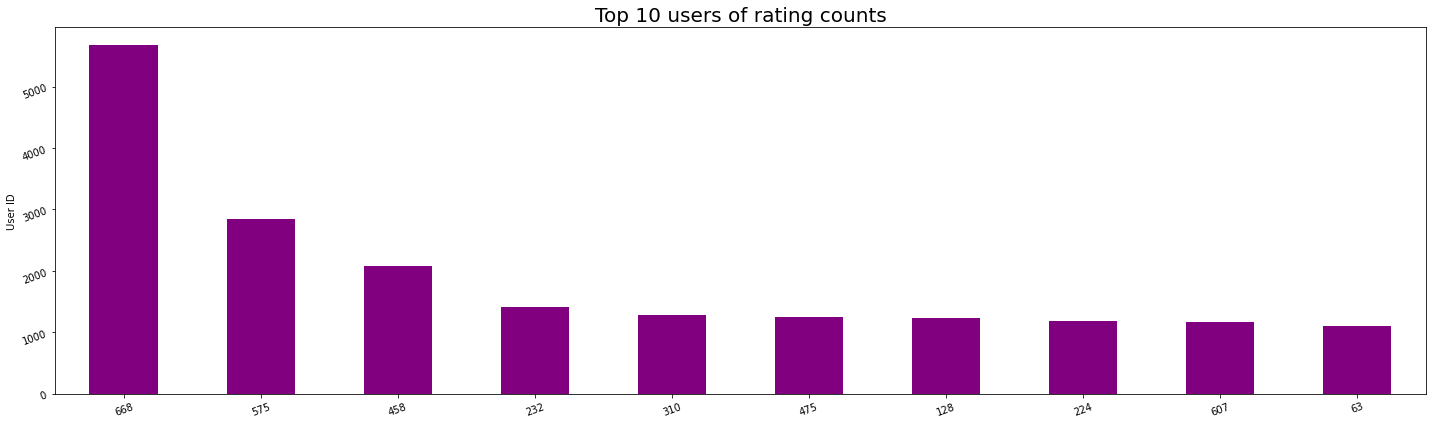

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20,6))
ratings_df['userId'].value_counts()[:10].plot(kind = 'bar', ax = ax, color="purple")
ax.set_title('Top 10 users of rating counts', fontsize = 20)
ax.tick_params(labelrotation = 20)
ax.set_ylabel('Count')
ax.set_ylabel('User ID')
plt.tight_layout()


**Timeseries Number of movies released per year**

The massive number of movies relaesed between 1992-2000.  It’s worth doing some research and asking questions to a domain expert to determine what could of happened during this period.

In [ ]:
all_movies["year"] = all_movies["title"].str.extract("\((\d{4})\)", expand=True)
year_counts = all_movies[["title", "year"]].groupby("year").size()

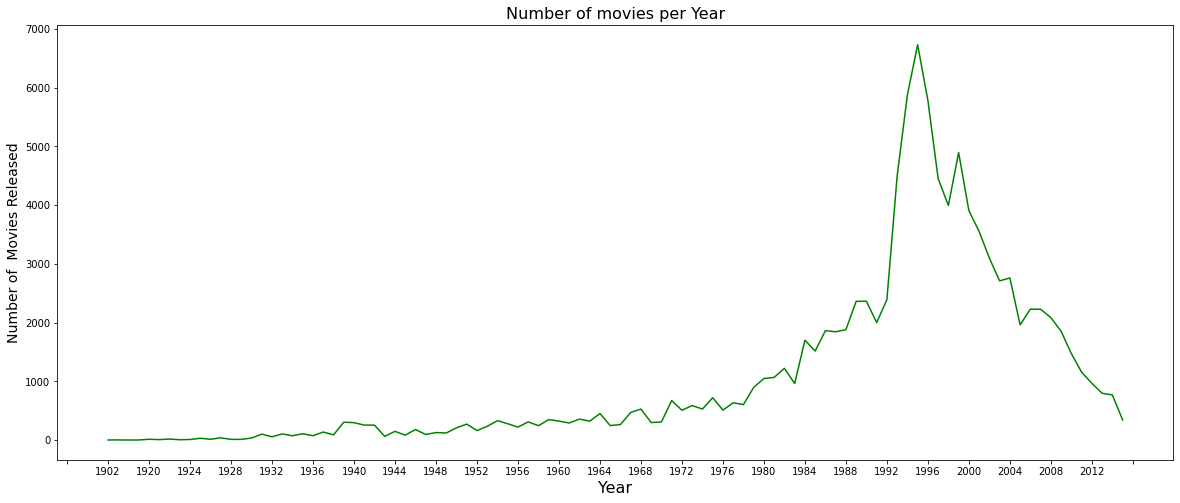

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(year_counts.index, year_counts.values,color='green')
ax.xaxis.set_major_locator(plt.MaxNLocator(30)) 
plt.title("Number of movies per Year", fontsize=16)
plt.xlabel("Year", fontsize= 16)
plt.ylabel("Number of  Movies Released", fontsize=14)
plt.show()

In [ ]:
missing = all_movies.isnull().sum().sort_values(ascending=False)
missing

year         7
timestamp    4
rating       4
userId       4
genres       0
title        0
movieId      0
dtype: int64

***Geners columns for clustering***

Taking a subset of users, and seeing what their preferred genres are.



In [ ]:
ratings = ratings_df
movies = movies_df
genres= ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir' ]
column_names = ['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]
genre_ratings = pd.DataFrame()
for genre in genres:        
  genre_movies = movies[movies['genres'].str.contains(genre) ]
  avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
  genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
genre_ratings.columns = column_names
genre_ratings.head()



,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Fantasy,avg_Romance,avg_Drama,avg_Action,avg_Crime,avg_Thriller,avg_Horror,avg_Mystery,avg_Sci-Fi,avg_IMAX,avg_War,avg_Musical,avg_Documentary,avg_Western,avg_Film-Noir
1,3.69,4.00,3.17,3.27,3.81,3.34,3.84,3.83,4.21,3.87,3.69,3.81,3.40,3.88,4.20,4.00,0.5,3.5,4.00
2,4.00,4.50,4.33,3.55,4.25,3.75,4.36,3.89,4.33,3.92,NaN,3.50,3.80,NaN,NaN,4.00,NaN,NaN,NaN
3,3.44,3.50,3.80,3.74,3.40,3.64,3.97,3.23,4.00,3.71,4.00,4.25,3.33,4.00,3.67,3.67,5.0,4.0,NaN
4,4.24,4.75,4.33,4.02,4.25,4.16,4.34,3.79,3.94,3.72,3.50,4.40,4.33,NaN,4.56,4.33,NaN,4.2,4.33
5,3.55,4.10,3.90,3.44,3.84,3.74,2.68,2.76,2.58,1.77,3.00,2.67,3.67,4.28,0.50,4.09,NaN,NaN,NaN


In [ ]:
genre_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 1 to 668
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   avg_Adventure    667 non-null    float64
 1   avg_Animation    573 non-null    float64
 2   avg_Children     614 non-null    float64
 3   avg_Comedy       667 non-null    float64
 4   avg_Fantasy      645 non-null    float64
 5   avg_Romance      663 non-null    float64
 6   avg_Drama        668 non-null    float64
 7   avg_Action       666 non-null    float64
 8   avg_Crime        663 non-null    float64
 9   avg_Thriller     666 non-null    float64
 10  avg_Horror       596 non-null    float64
 11  avg_Mystery      621 non-null    float64
 12  avg_Sci-Fi       659 non-null    float64
 13  avg_IMAX         448 non-null    float64
 14  avg_War          601 non-null    float64
 15  avg_Musical      538 non-null    float64
 16  avg_Documentary  250 non-null    float64
 17  avg_Western      469 

**Removing NaN values from the genre_ratings dataframe table**

In [ ]:
assert isinstance(genre_ratings, pd.DataFrame)
genre_ratings.dropna(inplace=True)
indices_to_keep = ~genre_ratings.isin([np.nan, np.inf, -np.inf]).any(1)
final_k_mean_df = genre_ratings[indices_to_keep].astype(np.float64)

final_k_mean_df.head()

,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Fantasy,avg_Romance,avg_Drama,avg_Action,avg_Crime,avg_Thriller,avg_Horror,avg_Mystery,avg_Sci-Fi,avg_IMAX,avg_War,avg_Musical,avg_Documentary,avg_Western,avg_Film-Noir
1,3.69,4.00,3.17,3.27,3.81,3.34,3.84,3.83,4.21,3.87,3.69,3.81,3.40,3.88,4.20,4.00,0.5,3.50,4.0
7,3.57,3.50,2.40,3.50,3.21,3.83,3.44,3.74,3.85,3.72,3.57,3.86,3.54,3.17,3.64,5.00,4.0,3.00,5.0
22,2.81,3.77,3.10,3.10,3.11,3.22,3.45,2.73,3.39,3.23,3.10,3.43,2.82,4.50,2.55,2.72,2.5,2.00,3.5
28,3.44,3.75,3.62,3.43,3.09,3.71,3.55,3.25,3.40,3.32,4.00,3.60,3.71,4.00,3.15,3.67,4.0,3.17,4.0
44,3.28,3.42,3.63,3.37,3.58,3.52,3.20,3.16,3.12,3.20,3.27,3.58,3.35,0.50,3.22,3.08,4.5,3.20,4.5


# Machine Learning Algorithms

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

for k in K:
	kmeanModel = KMeans(n_clusters=k).fit(final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]])
	kmeanModel.fit(final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]])
	distortions.append(sum(np.min(cdist(final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]], kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]].shape[0])
	inertias.append(kmeanModel.inertia_)
	mapping1[k] = sum(np.min(cdist(final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]], kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]].shape[0]
	mapping2[k] = kmeanModel.inertia_


In [ ]:
for key, val in mapping1.items():
	print(f'{key} : {val}')


1 : 2.389696497020996
2 : 1.9200224484341972
3 : 1.7206261821706181
4 : 1.685113155820515
5 : 1.619998331510153
6 : 1.5597856235395535
7 : 1.518752756192837
8 : 1.4857124945736195
9 : 1.4591496201741951


**Elbow method**

We can cluster our points into any number of clusters. What's the right number of clusters for this dataset?

There are several ways of choosing the number of clusters, k. We'll look at a simple one called "the elbow method". The elbow method works by plotting the ascending values of k versus the total error calculated using that k.


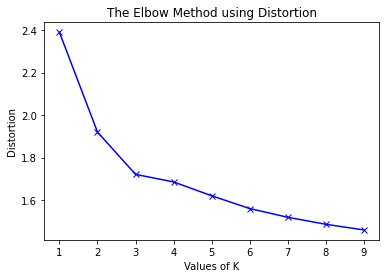

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


If we look at above graph, good choices for k include 3 or 4 amongst other values. Increasing the number of clusters (k) beyond that range starts to result in worse clusters according to elbow method.

My pick would be k=3 because it's easier to visualize:

**KMean Clustering**


Import KMeans Library

Prepare KMeans with n_clusters = 3

Pass the dataset final_k_mean_df to KMeans' fit_predict method and retrieve the clustering labels into predictions

In [ ]:
km_model = KMeans(n_clusters=3)
y_predicted = km_model.fit_predict(final_k_mean_df[['avg_Adventure', 'avg_Animation', 'avg_Children', 'avg_Comedy', 'avg_Fantasy', 'avg_Romance', 'avg_Drama', 'avg_Action', 'avg_Crime', 'avg_Thriller', 'avg_Horror', 'avg_Mystery', 'avg_Sci-Fi', 'avg_IMAX', 'avg_War', 'avg_Musical', 'avg_Documentary', 'avg_Western', 'avg_Film-Noir' ]])
y_predicted

array([2, 2, 0, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 0,
       2, 0, 2, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 0, 1, 2, 1, 1, 1,
       2, 2, 1, 1, 2, 1, 0, 2, 0, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 0, 2,
       2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 1, 2, 0, 1, 2, 0, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 2, 1, 1, 2,
       0, 2, 1, 2, 1, 2, 2, 2, 0], dtype=int32)

In [ ]:
final_k_mean_df['cluster']=y_predicted
final_k_mean_df.head()

,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Fantasy,avg_Romance,avg_Drama,avg_Action,avg_Crime,avg_Thriller,avg_Horror,avg_Mystery,avg_Sci-Fi,avg_IMAX,avg_War,avg_Musical,avg_Documentary,avg_Western,avg_Film-Noir,cluster
1,3.69,4.00,3.17,3.27,3.81,3.34,3.84,3.83,4.21,3.87,3.69,3.81,3.40,3.88,4.20,4.00,0.5,3.50,4.0,2
7,3.57,3.50,2.40,3.50,3.21,3.83,3.44,3.74,3.85,3.72,3.57,3.86,3.54,3.17,3.64,5.00,4.0,3.00,5.0,2
22,2.81,3.77,3.10,3.10,3.11,3.22,3.45,2.73,3.39,3.23,3.10,3.43,2.82,4.50,2.55,2.72,2.5,2.00,3.5,0
28,3.44,3.75,3.62,3.43,3.09,3.71,3.55,3.25,3.40,3.32,4.00,3.60,3.71,4.00,3.15,3.67,4.0,3.17,4.0,2
44,3.28,3.42,3.63,3.37,3.58,3.52,3.20,3.16,3.12,3.20,3.27,3.58,3.35,0.50,3.22,3.08,4.5,3.20,4.5,2


**KMean Clustering Plot**

We can see that the groups are mostly based on how each person rated romance movies. If their average rating of romance movies is over 3 stars, then they belong to one group. Otherwise, they belong to the other group.



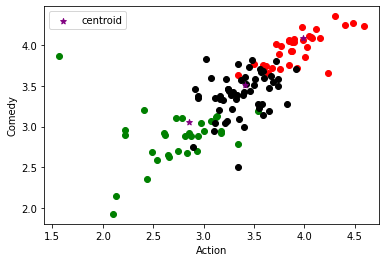

In [ ]:
plt.figsize=(10,10)
df1 = final_k_mean_df[final_k_mean_df.cluster==0]
df2 = final_k_mean_df[final_k_mean_df.cluster==1]
df3 = final_k_mean_df[final_k_mean_df.cluster==2]
plt.scatter(df1.avg_Action,df1['avg_Comedy'],color='green')
plt.scatter(df2.avg_Action,df2['avg_Comedy'],color='red')
plt.scatter(df3.avg_Action,df3['avg_Comedy'],color='black')
plt.scatter(km_model.cluster_centers_[:,0],km_model.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Action')
plt.ylabel('Comedy')
plt.legend()

**Classification Algorithms**

In [ ]:
final_k_mean_df.head()

,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Fantasy,avg_Romance,avg_Drama,avg_Action,avg_Crime,avg_Thriller,avg_Horror,avg_Mystery,avg_Sci-Fi,avg_IMAX,avg_War,avg_Musical,avg_Documentary,avg_Western,avg_Film-Noir,cluster
1,3.69,4.00,3.17,3.27,3.81,3.34,3.84,3.83,4.21,3.87,3.69,3.81,3.40,3.88,4.20,4.00,0.5,3.50,4.0,2
7,3.57,3.50,2.40,3.50,3.21,3.83,3.44,3.74,3.85,3.72,3.57,3.86,3.54,3.17,3.64,5.00,4.0,3.00,5.0,2
22,2.81,3.77,3.10,3.10,3.11,3.22,3.45,2.73,3.39,3.23,3.10,3.43,2.82,4.50,2.55,2.72,2.5,2.00,3.5,0
28,3.44,3.75,3.62,3.43,3.09,3.71,3.55,3.25,3.40,3.32,4.00,3.60,3.71,4.00,3.15,3.67,4.0,3.17,4.0,2
44,3.28,3.42,3.63,3.37,3.58,3.52,3.20,3.16,3.12,3.20,3.27,3.58,3.35,0.50,3.22,3.08,4.5,3.20,4.5,2


In [ ]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

In [ ]:
y = final_k_mean_df['cluster']
X  = final_k_mean_df.drop(['cluster'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Grid Search Cross Validation**


In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf',]}  
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
grid.fit(X_train, y_train) 

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.438, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.467, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.500, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........... C=10, gamma=1, kernel=rbf, score=0.625, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.812, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.625, total=   0.0s
[CV] C=10, gamma=1, kernel=rbf .......................................
[CV] ........... C=10, gamma=1, kernel=rbf, score=0.800, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=0.875, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] ......... C=10, gamma=0.1, kernel=rbf, score=1.000, total=   0.0s
[CV] C=10, gamma=0.1, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    0.5s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
grid_predictions = grid.predict(X_test) 
print(classification_report(y_test, grid_predictions)) 

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       1.00      1.00      1.00        11
           2       0.77      1.00      0.87        17

    accuracy                           0.88        40
   macro avg       0.92      0.86      0.87        40
weighted avg       0.90      0.88      0.87        40



**Naive Bayes**


In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.85


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rand_forest=RandomForestClassifier(random_state=42)


In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}


**Grid search cross validation**

In [ ]:
CV_forest = GridSearchCV(estimator=rand_forest, param_grid=param_grid, cv= 5)
CV_forest.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [ ]:
CV_forest.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
y_pred = CV_forest.predict(X_test)

In [ ]:
print("Accuracy for Random Forest : ",metrics.accuracy_score(y_test,y_pred))

Accuracy for Random Forest :  0.8


**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X_train

,avg_Adventure,avg_Animation,avg_Children,avg_Comedy,avg_Fantasy,avg_Romance,avg_Drama,avg_Action,avg_Crime,avg_Thriller,avg_Horror,avg_Mystery,avg_Sci-Fi,avg_IMAX,avg_War,avg_Musical,avg_Documentary,avg_Western,avg_Film-Noir
628,4.17,4.25,3.94,4.19,4.25,4.07,4.26,4.12,4.25,4.16,4.17,4.00,4.19,4.33,4.35,4.38,4.60,3.70,4.50
386,2.84,2.99,2.90,2.69,3.02,3.21,3.20,2.49,3.02,2.59,2.39,2.82,2.75,2.71,3.22,3.11,2.83,4.50,3.00
158,3.86,4.04,3.84,3.75,3.76,3.89,4.03,3.85,4.02,3.92,3.67,4.00,3.81,3.77,4.02,4.00,4.25,3.60,3.50
232,3.89,3.78,3.53,3.72,3.74,3.73,4.08,3.93,4.02,3.95,3.74,3.97,3.96,3.93,4.14,3.76,4.23,3.68,3.75
480,3.59,4.14,3.80,3.82,3.83,3.84,3.88,3.48,3.90,3.66,3.00,4.13,3.27,3.83,3.67,3.80,4.42,3.43,4.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,3.54,3.97,3.70,3.73,3.67,3.55,3.66,3.45,3.55,3.53,3.77,3.78,3.42,3.65,3.55,3.46,3.62,3.93,2.75
87,3.48,3.22,3.08,3.14,3.07,3.56,3.70,3.59,3.82,3.56,3.47,3.59,3.58,3.57,4.05,3.00,3.00,4.00,4.11
542,2.72,2.78,2.40,2.70,2.72,2.62,2.94,2.75,2.86,2.84,2.87,2.99,2.86,2.64,2.81,2.95,3.17,3.12,4.00
255,3.24,3.31,3.05,3.20,3.20,3.42,3.69,3.15,3.50,3.45,3.10,3.69,3.25,3.43,3.79,3.25,3.67,3.46,3.90


In [ ]:
y_train

628    1
386    0
158    1
232    1
480    2
      ..
590    2
87     2
542    0
255    2
575    0
Name: cluster, Length: 79, dtype: int32

In [ ]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(random_state=0).fit(X_train, y_train)

y_pred = logistic_regression.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Accuracy for Logistic Regression : ",metrics.accuracy_score(y_test,y_pred))

Accuracy for Logistic Regression :  0.85


**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
params = {'max_leaf_nodes': list(range(2, 100)),
          'min_samples_split': [2, 3, 4]}



grid_search_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_tree.fit(X_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 882 out of 882 | elapsed:    2.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,


In [ ]:
# Hyper-parameter tuning 
grid_search_tree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
y_pred = grid_search_tree.predict(X_test)

In [ ]:
print("Accuracy for Decision Tree : ",metrics.accuracy_score(y_test,y_pred))

Accuracy for Decision Tree :  0.775


**Geners Prediction**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
tf = tf_idf.fit_transform(movies_df['genres'])
print(tf)

  (0, 8)	0.47416052322404223
  (0, 4)	0.26383679738827265
  (0, 3)	0.5015063589597806
  (0, 2)	0.5392162328996213
  (0, 1)	0.40410291840105195
  (1, 8)	0.5928692758946519
  (1, 3)	0.6270612953422953
  (1, 1)	0.5052723558476101
  (2, 14)	0.7982318068971159
  (2, 4)	0.6023503818026228
  (3, 7)	0.43836988513685576
  (3, 14)	0.7174464867959467
  (3, 4)	0.5413893076052144
  (4, 4)	1.0
  (5, 16)	0.5312936407069773
  (5, 5)	0.6182409335327724
  (5, 0)	0.579228120388549
  (6, 14)	0.7982318068971159
  (6, 4)	0.6023503818026228
  (7, 3)	0.7786691857621576
  (7, 1)	0.627434697115563
  (8, 0)	1.0
  (9, 16)	0.5168457377333974
  (9, 0)	0.5634766958621668
  (9, 1)	0.6444877784776647
  :	:
  (10314, 7)	0.43836988513685576
  (10314, 14)	0.7174464867959467
  (10314, 4)	0.5413893076052144
  (10315, 7)	0.629286983758962
  (10315, 4)	0.7771730129588571
  (10316, 16)	0.8349099654267843
  (10316, 7)	0.5503865456486431
  (10318, 16)	0.617430888662782
  (10318, 0)	0.6731368601251884
  (10318, 7)	0.407020718472

**KNN Algorithm**

Get the cluster label to which movie belongs by KNN classifier from scikit-learn library.  

*Input*: movie_id

*output*: genres label to movie belong

In [ ]:
x= tf
y = movies_df.iloc[:,-1]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier  

KNN_model = KNeighborsClassifier(n_neighbors=5)

KNN_model.fit(x, y)

movie_id = input("Input movie id to get geners label to which movie belongs: ")
movie_id = int(movie_id)

y_pred = KNN_model.predict(tf[movie_id])
print(y_pred)

Input movie id to get geners label to which movie belongs: 2
['Comedy|Romance']


In [ ]:
all_movies[all_movies["movieId"]== movie_id]

,movieId,title,genres,userId,rating,timestamp
232,2,Jumanji (1995),Adventure|Children|Fantasy,16.0,3.0,1970-01-01 00:00:00.849188326
233,2,Jumanji (1995),Adventure|Children|Fantasy,29.0,4.0,1970-01-01 00:00:00.836818098
234,2,Jumanji (1995),Adventure|Children|Fantasy,31.0,4.0,1970-01-01 00:00:00.832397674
235,2,Jumanji (1995),Adventure|Children|Fantasy,32.0,3.0,1970-01-01 00:00:00.903225605
236,2,Jumanji (1995),Adventure|Children|Fantasy,38.0,2.0,1970-01-01 00:00:01.408318179
...,...,...,...,...,...,...
319,2,Jumanji (1995),Adventure|Children|Fantasy,650.0,4.0,1970-01-01 00:00:00.965502886
320,2,Jumanji (1995),Adventure|Children|Fantasy,655.0,3.5,1970-01-01 00:00:01.255910655
321,2,Jumanji (1995),Adventure|Children|Fantasy,656.0,3.0,1970-01-01 00:00:00.838777702
322,2,Jumanji (1995),Adventure|Children|Fantasy,662.0,5.0,1970-01-01 00:00:00.945179853


# Content Based Filtering Model

calculates top movies to be recommended to user based on movie user has watched. And removing already watched movie from recommended list.

*input*: user Id

*output*: Top movies based on movie user has watched.  

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
cosine_sim_movies = linear_kernel(tf, tf)
def get_recommendations_by_geners(title, sim_movies=cosine_sim_movies):
    movie_index = movies_df.loc[movies_df['title'].isin([title])]
    movie_index = movie_index.index
    movies_similarity_score = list(enumerate(sim_movies[movie_index][0]))
    movies_similarity_score = sorted(movies_similarity_score, key=lambda x: x[1], reverse=True)
    movies_similarity_score = movies_similarity_score[1:3]
    indices_movie = [i[0] for i in movies_similarity_score]
    return movies_df['title'].iloc[indices_movie]

In [ ]:
userId=input("Input User Id to Recommend Top movies based on movie user has watched: ")
userId = int(userId)

recommended = []
movie_list = []
user_rated = ratings_df[ratings_df["userId"]== userId]
for key, row in user_rated.iterrows():
  movie_list.append((movies_df["title"][row["movieId"]==movies_df["movieId"]]).values) 
for index, movie in enumerate(movie_list):
  for key, movie_recommended in get_recommendations_by_geners(movie[0]).iteritems():
    recommended.append(movie_recommended)

# removing already watched movie from recommended list    
for movie_title in recommended:
  if movie_title in movie_list:
    recommended.remove(movie_title)
set(recommended)

Input User Id to Recommend Top movies based on movie user has watched: 3


{'39 Steps, The (1935)',
 'Ace Ventura: When Nature Calls (1995)',
 'Almost Heroes (1998)',
 'Anne Frank Remembered (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Assassins (1995)',
 'Backbeat (1993)',
 'Barb Wire (1996)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Big Bully (1996)',
 'Big Trouble in Little China (1986)',
 'Catwoman (2004)',
 'City Hall (1996)',
 "City Slickers II: The Legend of Curly's Gold (1994)",
 'Clueless (1995)',
 'Dangerous Minds (1995)',
 "Dead Men Don't Wear Plaid (1982)",
 'Dial M for Murder (1954)',
 'Dungeons & Dragons (2000)',
 'Dunston Checks In (1996)',
 'Escape from L.A. (1996)',
 'Fantasia 2000 (1999)',
 'Flintstones, The (1994)',
 'Four Rooms (1995)',
 'Freeway (1996)',
 'Game, The (1997)',
 'Hanna (2011)',
 'Heavyweights (Heavy Weights) (1995)',
 'Henry: Portrait of a Serial Killer (1986)',
 'Henry: Portrait of a Serial Killer, Part 2 (1998)',
 'Hercules (1997)',
 'Impostor (2002)',
 'Independence Day (a.k.a. ID4) (1996)',
 'Juror, The (1996)',
 "K

UserId entered above for movies recomendation by content based model.
Check the orignol data of this user in dataset.

In [ ]:
 all_movies[all_movies["userId"]== userId]

,movieId,title,genres,userId,rating,timestamp
394,5,Father of the Bride Part II (1995),Comedy,3.0,3.0,1970-01-01 00:00:00.841483936
570,7,Sabrina (1995),Comedy|Romance,3.0,3.0,1970-01-01 00:00:00.841484087
786,11,"American President, The (1995)",Comedy|Drama|Romance,3.0,4.0,1970-01-01 00:00:00.841483689
1254,21,Get Shorty (1995),Comedy|Crime|Thriller,3.0,5.0,1970-01-01 00:00:00.841483620
1893,34,Babe (1995),Children|Drama,3.0,5.0,1970-01-01 00:00:00.841483604
...,...,...,...,...,...,...
19399,613,Jane Eyre (1996),Drama|Romance,3.0,4.0,1970-01-01 00:00:00.848052408
19633,648,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller,3.0,4.0,1970-01-01 00:00:00.841483842
20686,736,Twister (1996),Action|Adventure|Romance|Thriller,3.0,3.0,1970-01-01 00:00:00.841483822
22036,800,Lone Star (1996),Drama|Mystery|Western,3.0,5.0,1970-01-01 00:00:00.841484158


# Collaborative Filtering Model


**Memory Based Collaborative Filtering**

In [ ]:
all_movies.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1970-01-01 00:00:01.303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,5.0,1970-01-01 00:00:00.858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.0,1970-01-01 00:00:00.850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.0,1970-01-01 00:00:00.851766286


**Item-Item Matrix**

rows as MovieId and columns as movieId. because item-item similarity. and values are similarities between movie-movie pair.

Diagonals are zero because same movieId (1x1). Both are same movie can't compare similarity so zero.

In [ ]:
item_item_matrix = all_movies.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
item_item_matrix.fillna( 0, inplace = True )
item_item_matrix.shape


(10325, 668)

In [ ]:
from sklearn.metrics import pairwise_distances
movie_similarity = 1 - pairwise_distances( item_item_matrix, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
item_item_matrix = pd.DataFrame( movie_similarity )
item_item_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10285,10286,10287,10288,10289,10290,10291,10292,10293,10294,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304,10305,10306,10307,10308,10309,10310,10311,10312,10313,10314,10315,10316,10317,10318,10319,10320,10321,10322,10323,10324
0,0.000000,0.383068,0.337453,0.134724,0.360289,0.392823,0.347485,0.092432,0.123093,0.368602,0.308194,0.171755,0.144446,0.171986,0.175601,0.289442,0.393246,0.196601,0.301161,0.111417,0.315903,0.210951,0.171471,0.199389,0.354157,0.164223,0.078304,0.130158,0.266272,0.079406,0.218151,0.456723,0.057542,0.436689,0.066443,0.371301,0.366395,0.050019,0.173352,0.095162,...,0.000000,0.049321,0.082202,0.065762,0.000000,0.034525,0.000000,0.000000,0.000000,0.000000,0.049321,0.0,0.065762,0.000000,0.049321,0.057542,0.065762,0.057542,0.049321,0.049321,0.000000,0.000000,0.000000,0.000000,0.000000,0.073982,0.000000,0.030811,0.000000,0.057542,0.065762,0.000000,0.075491,0.000000,0.052609,0.0,0.0,0.000000,0.060148,0.000000
1,0.383068,0.000000,0.199207,0.123377,0.216562,0.302732,0.201137,0.056784,0.103498,0.422472,0.323679,0.210657,0.198711,0.055364,0.212559,0.335861,0.229578,0.158741,0.426233,0.137090,0.340297,0.176538,0.155600,0.268736,0.258521,0.096594,0.185546,0.129326,0.165237,0.173445,0.266440,0.331979,0.090899,0.292207,0.122454,0.216898,0.358039,0.089472,0.092992,0.088318,...,0.090899,0.090899,0.000000,0.090899,0.075749,0.084839,0.000000,0.075749,0.060599,0.090899,0.090899,0.0,0.000000,0.090899,0.090899,0.000000,0.090899,0.000000,0.090899,0.090899,0.075749,0.090899,0.090899,0.090899,0.090899,0.000000,0.106048,0.056784,0.090899,0.000000,0.090899,0.090899,0.052834,0.090899,0.127258,0.0,0.0,0.090899,0.099767,0.090899
2,0.337453,0.199207,0.000000,0.173366,0.514108,0.312031,0.338144,0.173191,0.228211,0.159173,0.223495,0.238936,0.124915,0.260748,0.109074,0.173836,0.224579,0.182781,0.209649,0.093059,0.200088,0.193597,0.125939,0.244593,0.340944,0.179573,0.064676,0.073618,0.171833,0.116901,0.164761,0.243615,0.000000,0.172392,0.045733,0.369083,0.234874,0.099233,0.105908,0.060588,...,0.000000,0.079212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.079212,0.0,0.000000,0.000000,0.079212,0.000000,0.000000,0.000000,0.079212,0.079212,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049483,0.000000,0.000000,0.000000,0.000000,0.046041,0.000000,0.000000,0.0,0.0,0.000000,0.047422,0.000000
3,0.134724,0.123377,0.173366,0.000000,0.127038,0.173900,0.098651,0.190777,0.028099,0.166986,0.147404,0.044936,0.091732,0.000000,0.280349,0.133756,0.100825,0.224556,0.073815,0.166046,0.172109,0.239911,0.155374,0.112357,0.180625,0.000000,0.346322,0.231265,0.052787,0.191206,0.243299,0.144396,0.000000,0.183924,0.235091,0.144429,0.155021,0.194327,0.235091,0.277781,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
4,0.360289,0.216562,0.514108,0.127038,0.000000,0.228020,0.418153,0.188991,0.133090,0.174580,0.249100,0.157891,0.136311,0.225759,0.216738,0.145103,0.282556,0.169585,0.183725,0.026436,0.215914,0.163395,0.115440,0.219630,0.284652,0.139312,0.077193,0.071594,0.097396,0.074413,0.141543,0.211316,0.000000,0.193443,0.054584,0.282904,0.310093,0.040607,0.102847,0.053942,...,0.000000,0.094542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094542,0.0,0.113450,0.000000,0.094542,0.000000,0.000000,0.000000,0.094542,0.094542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059060,0.000000,0.000000,0.000000,0.000000,0.054951,0.000000,0.000000,0.0,0.0,0.000000,0.056599,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

**Item-Item Collaborative Filtering Similarity**

This will take the movie title as a user input and will find the movies which are similar to this movie. This cell first find the index of movie in movies frame and then take the similarity of movie and align in movies dataframe so that we can get the similarity of the movie with all other movies.

Input: Movie Tital including (year).

output: similarity columns with similarity of that movie given in input.


In [ ]:
input_movie_name=input('Enter the correct movie title based on which similar movies will be fetched: ') #movie title should belong to dataset
#input_movie_name= "Toy Story (1995)"
get_movies=movies_df[movies_df['title']==input_movie_name].index.tolist()
get_movies_inp=get_movies[0]
movies_df['similarity'] = item_item_matrix.iloc[get_movies_inp]
movies_df.columns = ['movieId', 'title', 'geners','similarity']
movies_df.head()

Enter the correct movie title based on which similar movies will be fetched: Toy Story (1995)


,movieId,title,geners,similarity
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0.000000
1,2,Jumanji (1995),Adventure|Children|Fantasy,0.383068
2,3,Grumpier Old Men (1995),Comedy|Romance,0.337453
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0.134724
4,5,Father of the Bride Part II (1995),Comedy,0.360289


In [ ]:
def fetch_similar_items(title): 
  user_inp=title
  inp=movies_df[movies_df['title']==user_inp].index.tolist()
  inp=inp[0]

  movies_df['similarity'] = user_item_matrix.iloc[inp]
  movies_df.columns = ['movieId', 'title', 'geners','similarity']

**Recommend Top 10 movies** 

Recommend top10 movies to user based on item-item Similarity. Here we provide the user id of the user for which we have to recommend movies. Then we find the movies which are rated 5 or 4.5 by the user for whom we want to recommend movies. We are finding this because as we know that in Item-Item similarity approach we recommended movies to the user based on his previous selection. 


input: user_id

output: Recommend top 10 movies based on item-item similarity.

In [ ]:
user_id=input("Input User Id to Recommend top10 movies to user based on item-item Similarity: ")
user_movie= all_movies[(all_movies.userId==user_id) & all_movies.rating.isin([5,4.5])][['title']]
#user_movie=user_movie.iloc[0,0]
fetch_similar_items(user_movie)
sorted_movies_as_per_userChoice=movies_df.sort_values( ["similarity"], ascending = False )
sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movieId']
recommended_movies=list()
df_recommended_item=pd.DataFrame()
user2Movies= ratings_df[ratings_df['userId']== user_id]['movieId']
for movieId in sorted_movies_as_per_userChoice:
  if movieId not in user2Movies:
    df_new= ratings_df[(ratings_df.movieId==movieId)]
    df_recommended_item=pd.concat([df_recommended_item,df_new])
    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
best10['movieId']
movie_titles= list()
for id in best10['movieId']:
  print(movies_df[movies_df['movieId']==id]['title'].values)


Input User Id to Recommend top10 movies to user based on item-item Similarity: 2
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
['Star Wars: Episode IV - A New Hope (1977)']
['Dangerous Minds (1995)']
['Star Wars: Episode IV - A New Hope (1977)']
['Star Wars: Episode IV - A New Hope (1977)']
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
['Star Wars: Episode IV - A New Hope (1977)']
['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']
['Star Wars: Episode IV - A New Hope (1977)']


**User-Item Collaborative Filtering Similarity**

In similar way as we did for Item-Item similarity we will create a matrix but here we will keep rows as user and columns as movieId as we want a vector of different users. Then in similar ways we will find distance and similarity between users.





In [ ]:
user_item_matrix = ratings_df.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
user_item_matrix.fillna( 0, inplace = True )
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,...,139920,140098,140110,140247,140265,140711,140715,140725,140737,140777,140816,140820,141305,141432,141472,141688,142074,142448,142488,142507,142536,142550,142562,142566,142973,143031,143257,143385,143709,143882,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movie_similarity = 1 - pairwise_distances(user_item_matrix, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
user_item_matrix = pd.DataFrame( movie_similarity )
user_item_matrix.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667
0,0.000000,0.101113,0.210044,0.128766,0.057896,0.077130,0.358090,0.097434,0.239189,0.026663,0.175067,0.059797,0.076697,0.094746,0.089077,0.204081,0.306639,0.268693,0.062818,0.04241,0.171823,0.209750,0.172704,0.170970,0.067370,0.156348,0.114060,0.226782,0.254053,0.385564,0.182013,0.197529,0.157760,0.077971,0.113964,0.236894,0.126540,0.240310,0.216824,0.008492,...,0.269128,0.184986,0.207954,0.277360,0.402729,0.199971,0.213463,0.165790,0.180273,0.084249,0.204240,0.107387,0.102487,0.165240,0.174132,0.117887,0.000000,0.230487,0.034438,0.065871,0.145154,0.107574,0.082835,0.099325,0.114153,0.263522,0.186966,0.165544,0.020227,0.145951,0.291162,0.144741,0.106583,0.091049,0.236805,0.154519,0.245071,0.238660,0.278217,0.153479
1,0.101113,0.000000,0.115559,0.034610,0.032705,0.028305,0.062914,0.471918,0.194232,0.000000,0.159791,0.019189,0.000000,0.510366,0.000000,0.119452,0.060576,0.015841,0.000000,0.00000,0.021880,0.063312,0.019659,0.011385,0.032258,0.000000,0.028087,0.174960,0.215953,0.102826,0.155587,0.077349,0.024646,0.061783,0.374950,0.000000,0.054339,0.095952,0.065593,0.000000,...,0.032841,0.000000,0.143844,0.098996,0.125871,0.046104,0.090520,0.058567,0.074666,0.000000,0.031179,0.299879,0.021978,0.018655,0.000000,0.287954,0.069003,0.000000,0.000000,0.683034,0.000000,0.124544,0.000000,0.106667,0.052608,0.000000,0.075662,0.091534,0.042569,0.044203,0.068325,0.000000,0.477330,0.146887,0.163553,0.061737,0.050948,0.051423,0.035907,0.064816
2,0.210044,0.115559,0.000000,0.058208,0.044426,0.012816,0.084522,0.066620,0.459703,0.068454,0.230443,0.006206,0.052054,0.144890,0.036332,0.295242,0.065617,0.094354,0.016564,0.00000,0.029878,0.139436,0.039739,0.088832,0.137366,0.053577,0.018168,0.239785,0.308629,0.091503,0.325406,0.113006,0.057971,0.012403,0.098104,0.411714,0.067409,0.097354,0.198506,0.000000,...,0.065854,0.371568,0.189494,0.186400,0.199847,0.087543,0.166163,0.142476,0.082168,0.032024,0.032941,0.075618,0.036726,0.071797,0.076894,0.075048,0.026037,0.096661,0.036885,0.110455,0.048278,0.173318,0.020677,0.162527,0.219646,0.286046,0.086640,0.387322,0.035567,0.035741,0.152078,0.301021,0.081626,0.098949,0.310234,0.079452,0.092821,0.080940,0.158943,0.109648
3,0.128766,0.034610,0.058208,0.000000,0.019298,0.005781,0.059089,0.024420,0.050572,0.000000,0.111763,0.007258,0.020546,0.025739,0.010197,0.043945,0.054335,0.048233,0.026151,0.00000,0.048552,0.046070,0.039410,0.243839,0.009151,0.063394,0.079677,0.093310,0.064089,0.064477,0.050218,0.269361,0.195253,0.062854,0.043024,0.039172,0.244610,0.064976,0.114834,0.000000,...,0.000000,0.043819,0.136151,0.099209,0.099980,0.125218,0.111043,0.093040,0.062058,0.063667,0.047173,0.058443,0.013301,0.028788,0.078404,0.050757,0.048720,0.073786,0.000000,0.000000,0.011292,0.067161,0.033162,0.089299,0.049927,0.038692,0.062419,0.032314,0.036228,0.044140,0.055860,0.024329,0.040467,0.108881,0.076241,0.014011,0.042643,0.174275,0.061677,0.157794
4,0.057896,0.032705,0.044426,0.019298,0.000000,0.053378,0.080822,0.041536,0.023168,0.011915,0.069307,0.000000,0.011325,0.034050,0.058388,0.022178,0.076139,0.104778,0.003844,0.02762,0.006158,0.086743,0.033200,0.022431,0.021185,0.058511,0.031622,0.064019,0.054030,0.122683,0.064229,0.033532,0.013453,0.050371,0.000000,0.081782,0.000000,0.193116,0.018462,0.000000,...,0.154882,0.076085,0.009217,0.123043,0.091612,0.066418,0.057843,0.038225,0.063684,0.029418,0.019892,0.045779,0.011341,0.027303,0.049143,0.067148,0.014387,0.036135,0.002119,0.033290,0.056642,0.104415,0.000000,0.002224,0.015256,0.077980,0.133341,0.065363,0.016974,0.055573,0.058450,0.007315,0.024708,0.038163,0.053085,0.048993,0.055431,0.026053,0.086667,0.068275


**Similar Users with maximum similarity value in above Matrix**

Here now we have similarity of users in colums with respective users in row. So if we find maximum value in a column we will get the user with highest similarity. So now we can have a pair of users which are similar.

In [ ]:
similar_users = user_item_matrix.idxmax(axis=1).to_frame()
similar_users.columns=['similar_user']
similar_users.head()

,similar_user
0,347
1,95
2,244
3,321
4,37


**Recommending movies which user hasn't watched as per User-Item Similarity**


Input id of the user to whom we have to recommend movies. On basis of that, we find the user which is similar to that user and then filter the movies which are highly rated by the user to recommend them to given user.

Input: user_id to whom movie needs to be recommended

Output: movieIds to user based on user-item similarity movies which user hasn't watched as per User Similarity.

In [ ]:
movieId_recommended=list()
user_id=input("Input User Id to Recommend top10 movies to user based on user-item Similarity: ")
user_Movies= ratings_df[ratings_df['userId']== userId]['movieId']
sim_user=similar_users.iloc[0,0]
df_recommended=pd.DataFrame(columns=['movieId','title','genres','userId','rating','timestamp'])
for movieId in ratings_df[ratings_df['userId']== sim_user]['movieId']:
  if movieId not in user_Movies:
    df_new= all_movies[(all_movies.userId==sim_user) & (all_movies.movieId==movieId)]
    df_recommended=pd.concat([df_recommended,df_new])
    top_s10=df_recommended.sort_values(['rating'], ascending = False )[1:10]  
top_s10

Input User Id to Recommend top10 movies to user based on user-item Similarity: 2


,movieId,title,genres,userId,rating,timestamp
97214,65133,Blackadder Back & Forth (1999),Comedy,347.0,5.0,1970-01-01 00:00:01.274979943
83848,7323,"Good bye, Lenin! (2003)",Comedy|Drama,347.0,5.0,1970-01-01 00:00:01.274981629
92218,48516,"Departed, The (2006)",Crime|Drama|Thriller,347.0,5.0,1970-01-01 00:00:01.274980847
28244,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,347.0,5.0,1970-01-01 00:00:01.274978803
80881,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,347.0,5.0,1970-01-01 00:00:01.274981310
34531,1291,Indiana Jones and the Last Crusade (1989),Action|Adventure,347.0,5.0,1970-01-01 00:00:01.274979997
92938,50872,Ratatouille (2007),Animation|Children|Drama,347.0,5.0,1970-01-01 00:00:01.274980970
93050,51255,Hot Fuzz (2007),Action|Comedy|Crime|Mystery,347.0,5.0,1970-01-01 00:00:01.274981639
24192,924,2001: A Space Odyssey (1968),Adventure|Drama|Sci-Fi,347.0,5.0,1970-01-01 00:00:01.274981826


**Model Evaluations**

Returning common movies and ratings of same for both the users.

INPUT: user1 and user2 user ids for both 2 users need to compare.

OUTPUT: movieIds to user 

In [ ]:
user1 = input("Input User Id 1: ")
user1 = int(user1)
user2 = input("Input User Id 2: ")
user2 = int(user2)
similar_movies = all_movies[all_movies.userId == user1].merge(all_movies[all_movies.userId == user2], on = "movieId", how = "inner" )

similar_movies

Input User Id 1: 2
Input User Id 2: 4


,movieId,title_x,genres_x,userId_x,rating_x,timestamp_x,title_y,genres_y,userId_y,rating_y,timestamp_y
0,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,2.0,3.0,1970-01-01 00:00:00.859046895,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,4.0,5.0,1970-01-01 00:00:00.950323750
1,608,Fargo (1996),Comedy|Crime|Drama|Thriller,2.0,5.0,1970-01-01 00:00:00.859046959,Fargo (1996),Comedy|Crime|Drama|Thriller,4.0,4.0,1970-01-01 00:00:00.950323165


**Model Based Collaborative Filtering**


**Matrix Factorization (MF)**

Matrix factorization is an unsupervised learning method for latent variable decomposition and dimensionality reduction. this can deal better with scalability and sparsity than Memory based collaborative filterings.

In [ ]:
ratings_data = pd.read_csv('/content/drive/MyDrive/recommendations/ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating','timestamp'])
ratings_matrix = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
ratings_matrix.head()
#rows are user and columns are movies

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,...,139920,140098,140110,140247,140265,140711,140715,140725,140737,140777,140816,140820,141305,141432,141472,141688,142074,142448,142488,142507,142536,142550,142562,142566,142973,143031,143257,143385,143709,143882,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ratings_mean_per_user = np.mean(ratings_matrix, axis = 1)
#print(ratings_mean_per_user)
total_users = ratings_mean_per_user.size
total_movies = len(movies_df)
Ratings_dimentions = ratings_matrix - ratings_mean_per_user.values.reshape(-1,1)


sparsity = round(1.0 - len(ratings_matrix) / float(total_users * total_movies), 3)
print('The sparsity level of ratings dataset is ' +  str(sparsity * 100) + '%')


The sparsity level of ratings dataset is 100.0%


**Single Value Decompositon (SVD)**


Singular value decomposition (SVD) is the methode of matrix factorization. At a high level, SVD is an algorithm that decomposes a matrix (ratings_matrix) into the best lower rank and smaller. Mathematically, it decomposes a matrox into a two unitary matrices and a diagonal matrix: **Matrix -> U*S*Vt** .


U is the left singular vectors (user "features" matrix).

S is the diagonal matrix of singular values.

Vt is the right singluar vectors (movie "features" matrix).



In [ ]:
from scipy.sparse.linalg import svds

In [ ]:
U, S, Vt = svds(Ratings_dimentions, k = 50)

In [ ]:
U

array([[ 8.99150529e-03,  2.06688001e-02, -1.82787409e-02, ...,
         1.33980545e-02, -8.91701031e-03, -4.34594868e-02],
       [-7.02211897e-03,  8.52369117e-03, -2.06093463e-03, ...,
         1.35483022e-02,  1.10831323e-02, -7.28917571e-03],
       [-7.60339840e-03, -2.16570667e-02, -1.48513521e-02, ...,
         5.91162090e-02,  3.32692847e-02, -1.98287879e-02],
       ...,
       [ 1.59964621e-02, -1.52558874e-03,  2.98470628e-02, ...,
        -4.11685012e-02,  2.10758551e-02, -3.78406551e-02],
       [ 6.06185423e-03, -3.05389137e-03,  6.45705004e-03, ...,
         1.88700152e-02, -4.57420244e-03, -2.51302781e-02],
       [ 2.00714910e-04, -1.65049393e-02, -1.31357315e-02, ...,
        -3.65966498e-01,  3.21726441e-02, -9.29570839e-02]])

In [ ]:
S = np.diag(S)
S

array([[ 67.75583954,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  68.10174582,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  68.41554944, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 188.46765204,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        229.09814764,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 480.87123202]])

In [ ]:
Vt

array([[ 1.02328482e-02, -4.48934821e-03, -5.01349447e-03, ...,
         1.01312524e-03, -2.52574324e-03,  1.24258501e-03],
       [-9.77255054e-03,  2.85802295e-03,  2.42247054e-03, ...,
        -1.75274343e-03,  5.70463009e-03, -2.41625509e-03],
       [ 3.72650563e-02, -4.76742953e-03, -8.06559214e-03, ...,
        -7.77121997e-04,  3.84524967e-03, -1.10388500e-03],
       ...,
       [ 3.87145998e-02,  3.75903769e-02,  2.60274369e-02, ...,
         3.56085998e-03, -9.07085798e-03,  3.30080119e-03],
       [ 1.81274869e-02, -8.06214340e-04,  1.35117605e-02, ...,
         5.58976785e-05,  2.94962850e-04, -1.20500077e-04],
       [-8.03164042e-02, -3.17056020e-02, -9.42407409e-03, ...,
         4.40677960e-03,  2.13542969e-03,  4.26939746e-03]])

In [ ]:
print('Shape of U: ', U.shape)
print('Shape of S: ', S.shape)
print('Shape of Vt: ', Vt.shape)

Shape of U:  (668, 50)
Shape of S:  (50, 50)
Shape of Vt:  (50, 10325)


In [ ]:
ratings_predicted_for_users = np.dot(np.dot(U, S), Vt) + ratings_mean_per_user.values.reshape(-1,1)
preds = pd.DataFrame(all_user_predicted_ratings, columns = ratings_matrix.columns)
preds.head()
#print('All user predicted rating : ', ratings_predicted_for_users.shape)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,39,40,41,42,...,139920,140098,140110,140247,140265,140711,140715,140725,140737,140777,140816,140820,141305,141432,141472,141688,142074,142448,142488,142507,142536,142550,142562,142566,142973,143031,143257,143385,143709,143882,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
0,2.340908,0.116324,0.182888,-0.036764,0.063752,1.539780,0.101114,-0.025708,0.194963,0.992245,0.618147,-0.010391,-0.095024,0.287937,-0.143531,1.033729,0.716798,0.111639,0.234168,0.108559,0.926473,-0.154615,0.223366,-0.090888,0.625506,-0.071134,-0.067335,-0.010725,-0.163077,0.117091,-0.237404,3.235849,0.062935,0.788609,-0.003939,1.113220,0.224885,-0.027630,0.183916,0.079806,...,-0.005889,0.013000,0.000478,-0.021189,0.018228,-0.021520,-0.022743,0.014663,0.040616,-0.019312,0.013000,0.048145,0.004689,-0.019312,0.013000,-0.008007,-0.014009,0.023190,0.016280,0.015187,0.013475,-0.023786,-0.023786,-0.028260,-0.028260,0.029690,-0.005979,-0.039309,-0.023786,0.004943,-0.014009,-0.023786,-0.005130,-0.010363,-0.048034,-0.036938,-0.020261,-0.019312,0.007349,-0.028260
1,3.151773,0.206667,1.666566,-0.077891,1.485149,1.730959,1.173952,0.023590,0.766577,-0.211013,0.201427,0.443564,-0.071414,0.911231,-0.079210,0.217731,1.824973,0.333200,-0.008163,-0.044161,0.206467,0.003570,0.004746,0.130648,1.732287,0.345220,-0.027518,0.051581,0.750384,0.071334,0.015781,2.030842,-0.007261,0.148772,-0.033914,2.019855,0.072091,0.102383,0.218490,-0.028445,...,-0.007697,-0.001744,0.008822,-0.004967,-0.044137,-0.024248,0.011739,-0.031098,-0.002503,-0.010372,-0.001744,0.000860,-0.006952,-0.010372,-0.001744,-0.010980,-0.004981,-0.001212,0.000222,-0.000433,-0.026752,-0.011264,-0.011264,-0.012156,-0.012156,-0.005378,-0.018289,0.028086,-0.011264,-0.006015,-0.004981,-0.011264,-0.008696,-0.008589,-0.010318,0.017270,0.008911,-0.010372,-0.046182,-0.012156
2,0.991437,0.829049,0.553093,0.183691,0.576599,0.331009,0.773242,0.034812,0.014922,1.706305,1.965014,-0.010221,-0.000692,0.371488,0.116277,0.727336,1.851834,0.123356,0.701592,0.242227,2.389299,0.653387,0.339048,0.042433,1.300881,0.175863,0.048568,0.325909,0.196382,0.130430,0.535365,1.986404,0.006439,2.493926,0.045687,1.195020,1.773800,0.032462,0.240247,0.042537,...,-0.005432,-0.000562,-0.008008,0.006205,-0.068454,-0.008696,0.013788,-0.048550,-0.007835,-0.002121,-0.000562,0.012244,-0.009800,-0.002121,-0.000562,0.000377,0.002468,-0.009819,0.004346,0.002710,-0.041915,-0.001017,-0.001017,0.000087,0.000087,-0.004410,-0.017816,0.037996,-0.001017,-0.007223,0.002468,-0.001017,0.010078,-0.004328,0.012828,0.018177,0.008082,-0.002121,-0.041568,0.000087
3,0.619139,-0.217151,-0.238869,0.127655,-0.099769,0.117654,-0.102186,-0.058419,-0.008662,0.010188,-0.072984,0.082188,0.146236,0.211859,0.119608,0.514985,0.889405,0.040085,0.156484,0.028928,0.597476,0.218946,0.012295,-0.358085,0.638238,-0.170828,0.063849,0.355837,0.225302,0.583454,0.038242,0.473994,-0.000489,0.732896,0.096823,0.665625,-0.216679,0.160316,0.630512,0.278044,...,0.008801,-0.014839,0.026320,0.023691,-0.018097,-0.036834,-0.000418,-0.016184,-0.026077,0.029960,-0.014839,-0.016599,0.022835,0.029960,-0.014839,-0.028737,0.014678,-0.009817,-0.016328,-0.015832,-0.015547,0.037013,0.037013,0.044066,0.044066,0.011411,-0.020455,-0.015606,0.037013,-0.015088,0.014678,0.037013,-0.033948,0.015854,0.066009,-0.011781,-0.011998,0.029960,-0.044401,0.044066
4,1.636123,0.410191,0.087905,-0.022208,0.083438,-0.128785,-0.018924,0.016518,0.031642,0.311503,0.010816,0.050646,0.127814,0.041576,0.037627,0.097789,0.167618,0.041504,0.224768,-0.003764,0.096628,0.117710,0.085755,-0.009441,0.035618,0.067574,-0.017535,-0.049877,0.193993,0.050864,-0.121448,-0.061985,0.004312,0.620947,-0.011058,0.051214,0.225777,-0.002836,0.057314,0.056631,...,0.001721,0.004732,0.063102,0.032812,0.017094,0.007884,0.027528,0.013971,0.001544,-0.004282,0.004732,-0.001845,-0.012452,-0.004282,0.004732,0.005264,0.026540,0.009324,0.002937,0.

**Predictions for SVD**

**INPUT**: 

userID : UserId for which you want to predict the top rated movies

**OUTPUT**: 

top 10 movies

In [ ]:
user_ID = input()
userID = int(userID)
user_row_number = userID - 1
predictions = preds
sorted_user_predictions = predictions.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
user_data = all_movies[all_movies.userId == (userID)]
users = (user_data.merge(all_movies, how = 'left', left_on = 'movieId', right_on = 'movieId'))
print('User {0} has already rated {1} movies.'.format(userID, users.shape[0]))


recommend = (movies[~movies['movieId'].isin(users['movieId'])].merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',left_on = 'movieId', right_on = 'movieId').rename(columns = {user_row_number: 'Predictions'}).sort_values('Predictions', ascending = False).iloc[:10, :-1])

users.head(10)


2
User 2 has already rated 2913 movies.


,movieId,title_x,genres_x,userId_x,rating_x,timestamp_x,title_y,genres_y,userId_y,rating_y,timestamp_y
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1970-01-01 00:00:01.303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,5.0,1970-01-01 00:00:00.858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.0,1970-01-01 00:00:00.850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14.0,4.0,1970-01-01 00:00:00.851766286
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,5.0,1970-01-01 00:00:01.350206819
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,28.0,3.0,1970-01-01 00:00:00.884098350
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,29.0,4.0,1970-01-01 00:00:00.846942580
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,30.0,4.5,1970-01-01 00:00:01.292690069
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2.0,5.0,1970-01-01 00:00:00.859046895,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,31.0,4.0,1970-01-01 00:00:00.832397496


In [ ]:
print('Recommending top 10 predicted ratings movies not rated by user.')
recommend

Recommending top 10 predicted ratings movies not rated by user.


,movieId,title,geners,similarity
598,733,"Rock, The (1996)",Action|Adventure|Thriller,0.127282
943,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,NaN
106,141,"Birdcage, The (1996)",Comedy,0.068195
649,832,Ransom (1996),Crime|Thriller,NaN
628,786,Eraser (1996),Action|Drama|Thriller,0.114153
580,708,"Truth About Cats & Dogs, The (1996)",Comedy|Romance,0.198116
2,6,Heat (1995),Action|Crime|Thriller,0.077130
668,858,"Godfather, The (1972)",Crime|Drama,NaN
589,719,Multiplicity (1996),Comedy,0.354737
626,783,"Hunchback of Notre Dame, The (1996)",Animation|Children|Drama|Musical|Romance,0.107574
